In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle 
import os 
import numpy as np
import cv2 

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
import os 
import numpy as np
import cv2 
train = get_training_data('./DL/chest_xray/chest_xray/train/')
test = get_training_data('./DL/chest_xray/chest_xray/test/')
val = get_training_data('./DL/chest_xray/chest_xray/val/')

OpenCV(4.6.0) C:\b\abs_f8n1j3l9l0\croot\opencv-suite_1691622637237\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) C:\b\abs_f8n1j3l9l0\croot\opencv-suite_1691622637237\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\asus\AppData\Local\Temp\ipykernel_19220\4037217275.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.6.0) C:\b\abs_f8n1j3l9l0\croot\opencv-suite_1691622637237\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) C:\b\abs_f8n1j3l9l0\croot\opencv-suite_1691622637237\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [4]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


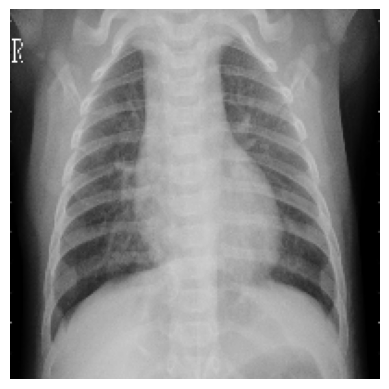

In [5]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [6]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [7]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [8]:
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=90, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=True)  

datagen.fit(X_train)

In [9]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
375/375 [==============================] - 396s 1s/step - loss: 0.6149 - acc: 0.7014 - val_loss: 0.7184 - val_acc: 0.7407
Epoch 2/10
375/375 [==============================] - 345s 917ms/step - loss: 0.4569 - acc: 0.7691 - val_loss: 0.3623 - val_acc: 0.8335
Epoch 3/10
375/375 [==============================] - 349s 930ms/step - loss: 0.4152 - acc: 0.8006 - val_loss: 0.3165 - val_acc: 0.8645
Epoch 4/10
375/375 [==============================] - 358s 956ms/step - loss: 0.3757 - acc: 0.8316 - val_loss: 0.2530 - val_acc: 0.9029
Epoch 5/10
375/375 [==============================] - 383s 1s/step - loss: 0.3347 - acc: 0.8497 - val_loss: 0.6075 - val_acc: 0.6756
Epoch 6/10
375/375 [==============================] - 405s 1s/step - loss: 0.3252 - acc: 0.8537 - val_loss: 0.3261 - val_acc: 0.8645
Epoch 7/10
375/375 [==============================] - 366s 975ms/step - loss: 0.3077 - acc: 0.8716 - val_loss: 0.2307 - val_acc: 0.8943
Epoch 8/10
375/375 [==============================] - 345

In [12]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 29s 797ms/step - loss: 0.2227 - acc: 0.9019


[0.22265580296516418, 0.9018771052360535]

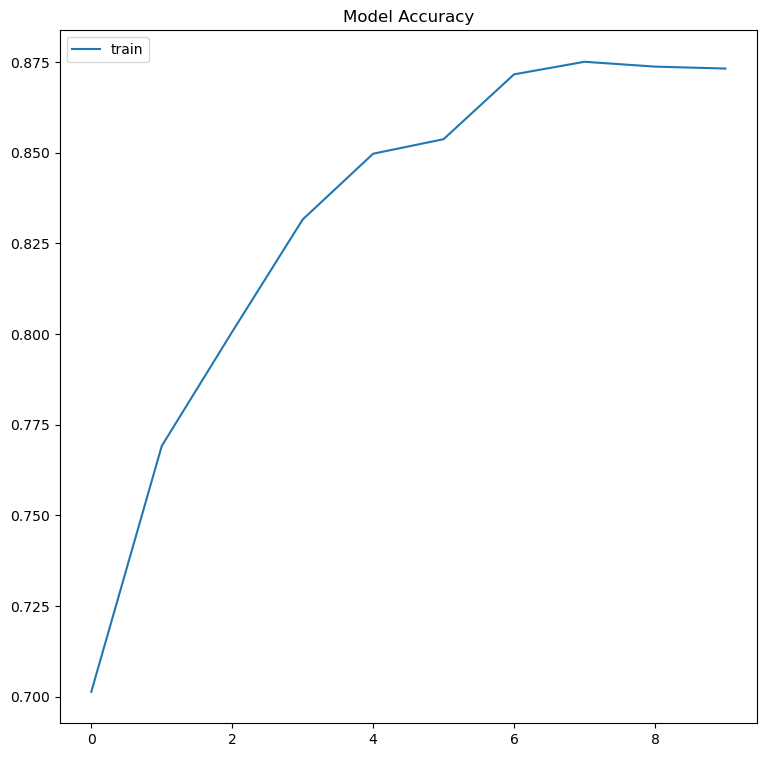

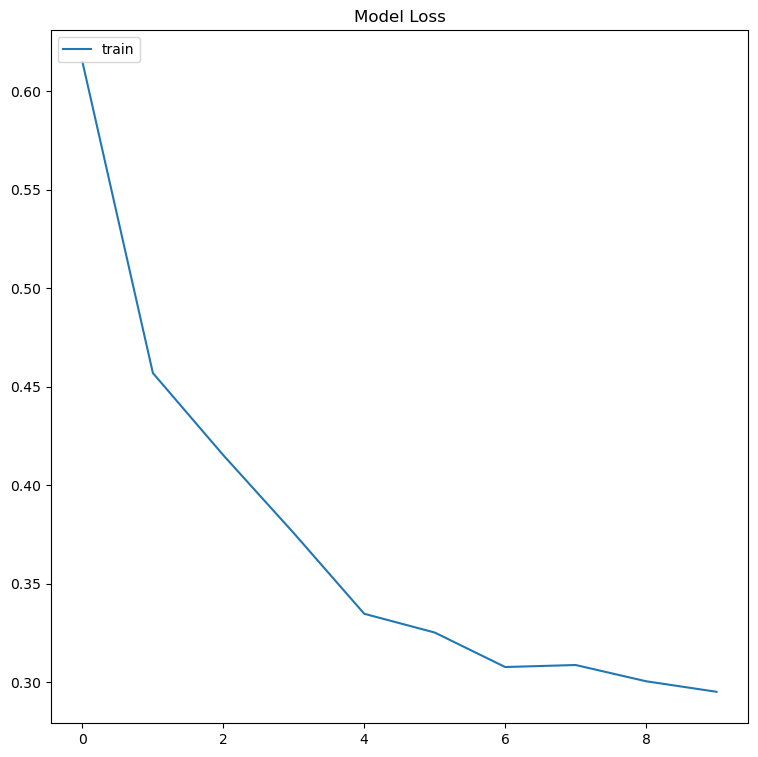

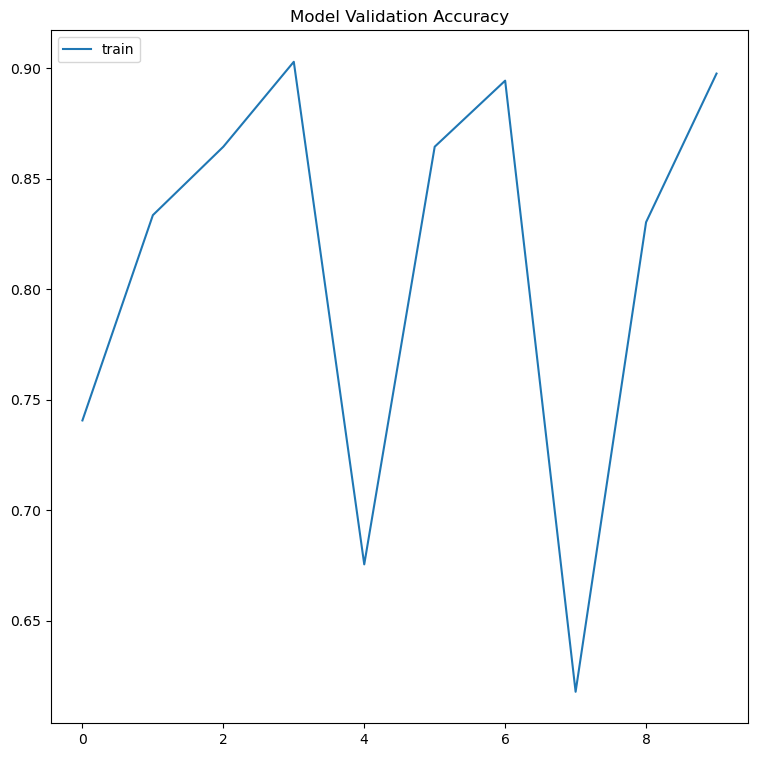

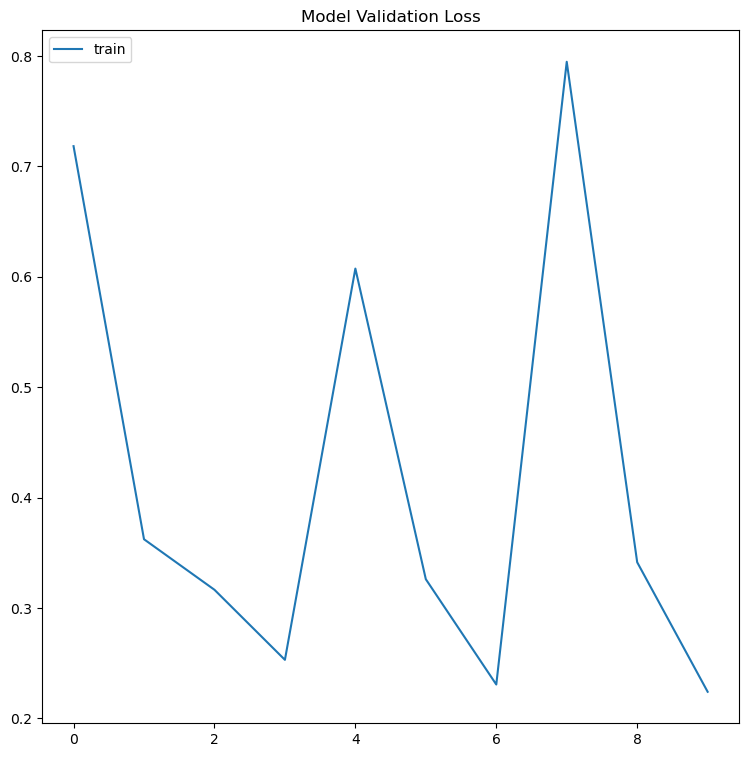

In [13]:
plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(9, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 96s 765ms/step


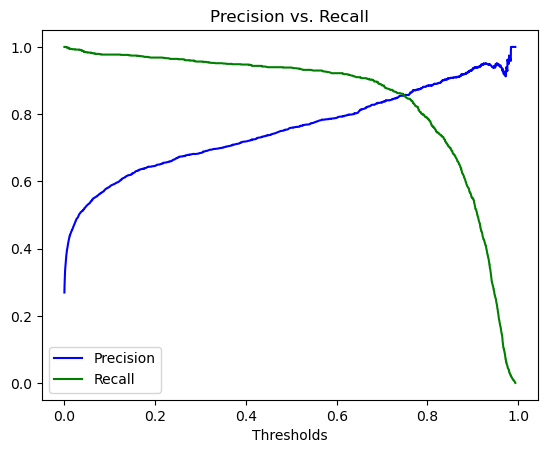

In [15]:
plt.plot(thresholds, precisions[:-1], 'b-')
plt.plot(thresholds, recalls[:-1], 'g-')
plt.title('Precision vs. Recall')
plt.xlabel('Thresholds')
plt.legend(['Precision', 'Recall'], loc='best')
plt.show()


In [16]:
predictions = model.predict(X_test)

37/37 [==============================] - 29s 791ms/step


In [17]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [18]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9215017064846417
Precision on testing set: 0.9270516717325228
Recall on testing set: 0.8176943699731903


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

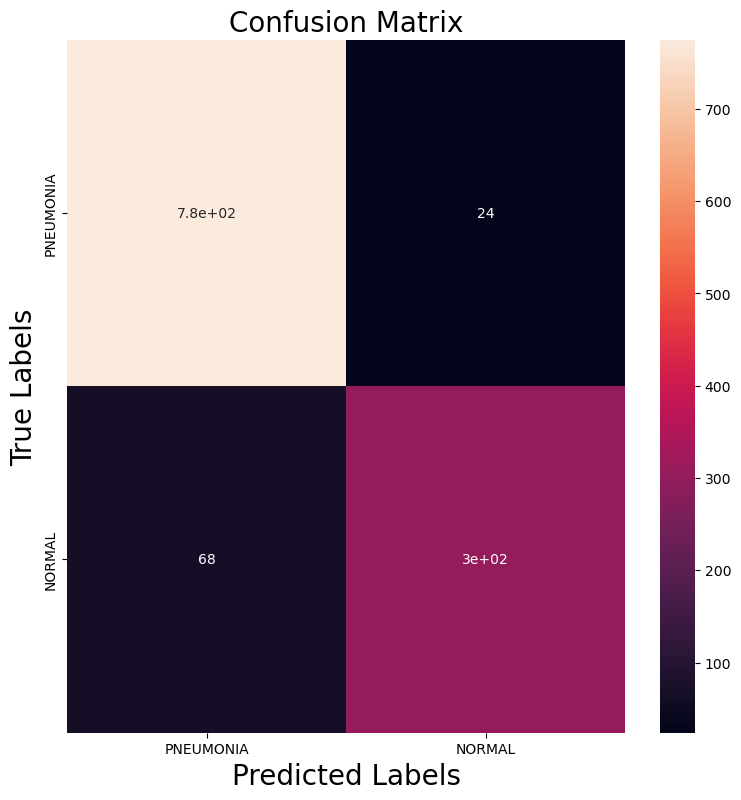

In [19]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt 
import seaborn as sns 
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [20]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(binary_predictions,y_test)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.92      0.97      0.94       799
           1       0.93      0.82      0.87       373

    accuracy                           0.92      1172
   macro avg       0.92      0.89      0.91      1172
weighted avg       0.92      0.92      0.92      1172



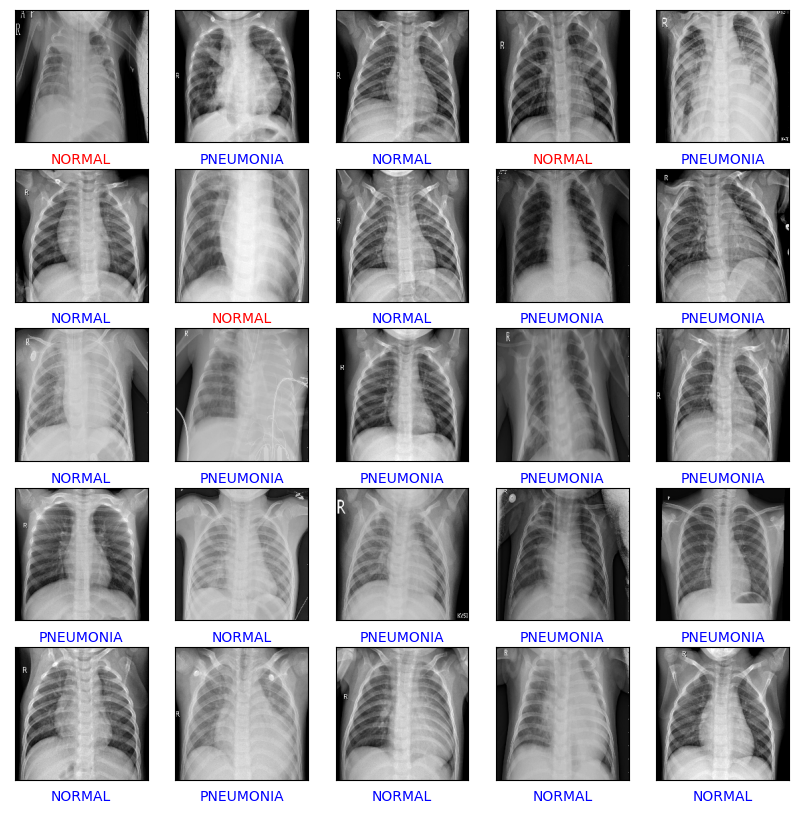

In [21]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [22]:
 model.save('pneumonia_detection_ai_version_3.h5')

In [23]:
import tensorflow.keras.layers as Layers
base_model = tf.keras.applications.MobileNetV2(input_shape=X_train.shape[1:],include_top=False,weights=None)
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))  
model.add(Dropout(0.1))
model.add(Layers.Dense(256, activation='relu'))
model.add(Layers.Dropout(0.1))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.01))  
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_200 (Funct  (None, 7, 7, 1280)       2257408   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)             

In [24]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[callbacks], validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
375/375 [==============================] - 63s 145ms/step - loss: 0.5922 - accuracy: 0.7302 - val_loss: 0.5854 - val_accuracy: 0.7407
Epoch 2/5
375/375 [==============================] - 50s 133ms/step - loss: 0.5865 - accuracy: 0.7302 - val_loss: 0.5808 - val_accuracy: 0.7407
Epoch 3/5
375/375 [==============================] - 50s 132ms/step - loss: 0.5865 - accuracy: 0.7302 - val_loss: 0.5727 - val_accuracy: 0.7407
Epoch 4/5
375/375 [==============================] - 47s 126ms/step - loss: 0.5846 - accuracy: 0.7302 - val_loss: 0.5811 - val_accuracy: 0.7407
Epoch 5/5
375/375 [==============================] - 48s 128ms/step - loss: 0.5860 - accuracy: 0.7302 - val_loss: 0.5726 - val_accuracy: 0.7407


In [26]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 12s 318ms/step - loss: 0.5940 - accuracy: 0.7193


[0.593982458114624, 0.7192832827568054]

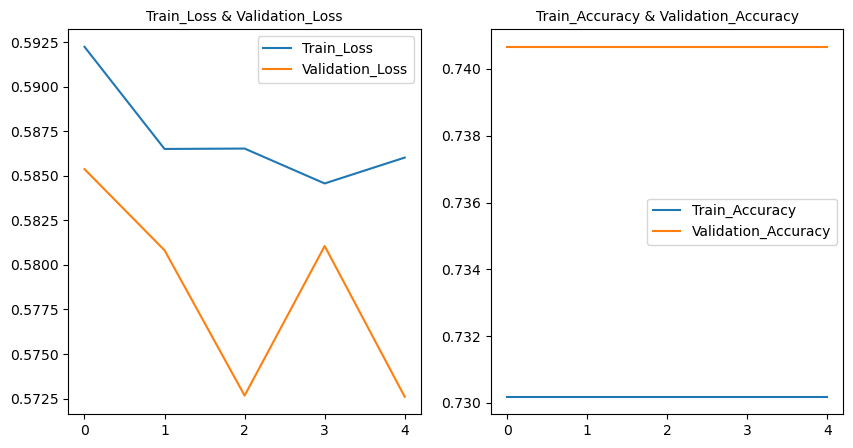

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'],label='Train_Loss')
plt.plot(history.epoch, history.history['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=10)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'],label='Train_Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=10)
plt.legend()

In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 32s 261ms/step


In [29]:
predictions = model.predict(X_test)

37/37 [==============================] - 10s 270ms/step


In [30]:
y_pred=np.where(predictions>=.5,1,0)

In [31]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(y_test,y_pred))

Accuracy on testing set: 0.7192832764505119


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

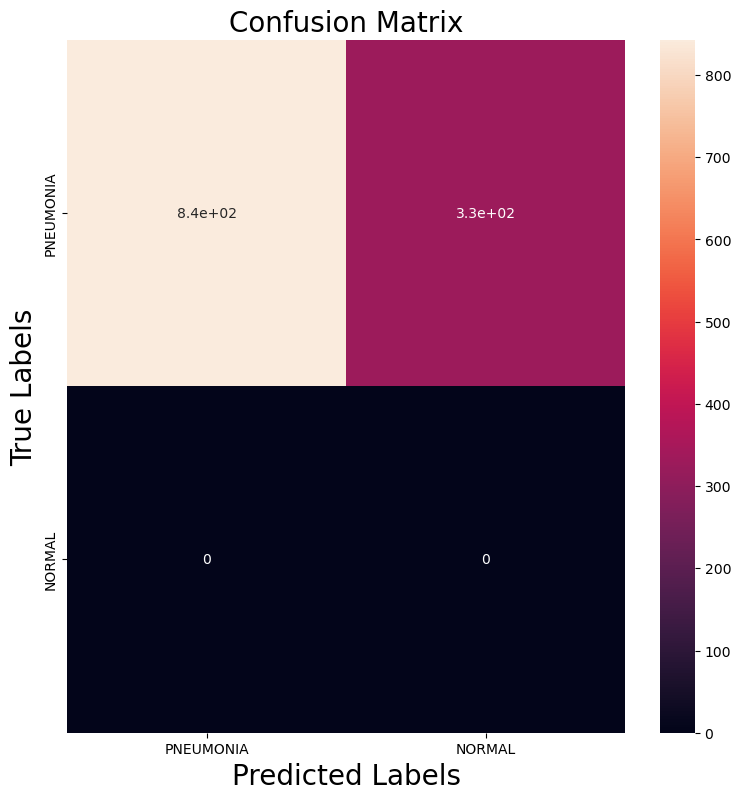

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt 
import seaborn as sns 
matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [33]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_pred,y_test)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.72      0.84      1172
           1       0.00      0.00      0.00         0

    accuracy                           0.72      1172
   macro avg       0.50      0.36      0.42      1172
weighted avg       1.00      0.72      0.84      1172



c:\Users\asus\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
base_model=tf.keras.applications.EfficientNetB0(weights = "imagenet", include_top = False, input_shape=(200, 200,3), pooling='max')
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.5))
model.add(Layers.Dense(256, activation='relu'))
model.add(Layers.Dropout(0.5))
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.1))  
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_7 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)              

In [35]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[callbacks], validation_data=(X_val, y_val), epochs=5)

Epoch 1/5
375/375 [==============================] - 90s 216ms/step - loss: 0.9200 - accuracy: 0.6677 - val_loss: 0.5787 - val_accuracy: 0.7407
Epoch 2/5
375/375 [==============================] - 74s 197ms/step - loss: 0.6095 - accuracy: 0.7280 - val_loss: 0.5767 - val_accuracy: 0.7407
Epoch 3/5
375/375 [==============================] - 75s 200ms/step - loss: 0.5854 - accuracy: 0.7299 - val_loss: 0.5724 - val_accuracy: 0.7407
Epoch 4/5
375/375 [==============================] - 73s 195ms/step - loss: 0.5843 - accuracy: 0.7302 - val_loss: 0.5735 - val_accuracy: 0.7407
Epoch 5/5
375/375 [==============================] - 76s 202ms/step - loss: 0.5839 - accuracy: 0.7297 - val_loss: 0.5773 - val_accuracy: 0.7407


In [37]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 16s 420ms/step - loss: 0.5950 - accuracy: 0.7193


[0.5949643850326538, 0.7192832827568054]

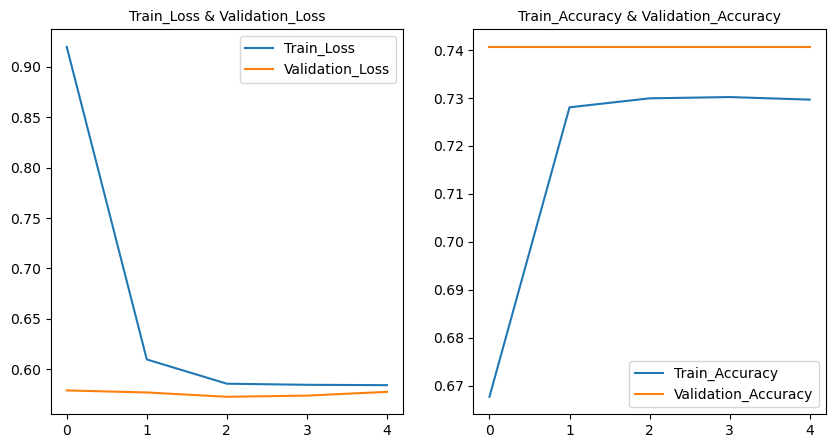

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'],label='Train_Loss')
plt.plot(history.epoch, history.history['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=10)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'],label='Train_Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=10)
plt.legend()

In [39]:
predictions = model.predict(X_test)

37/37 [==============================] - 18s 426ms/step


In [40]:
y_pred=np.where(predictions>=.5,1,0)

In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set:', accuracy_score(y_test,y_pred))

Accuracy on testing set: 0.7192832764505119


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

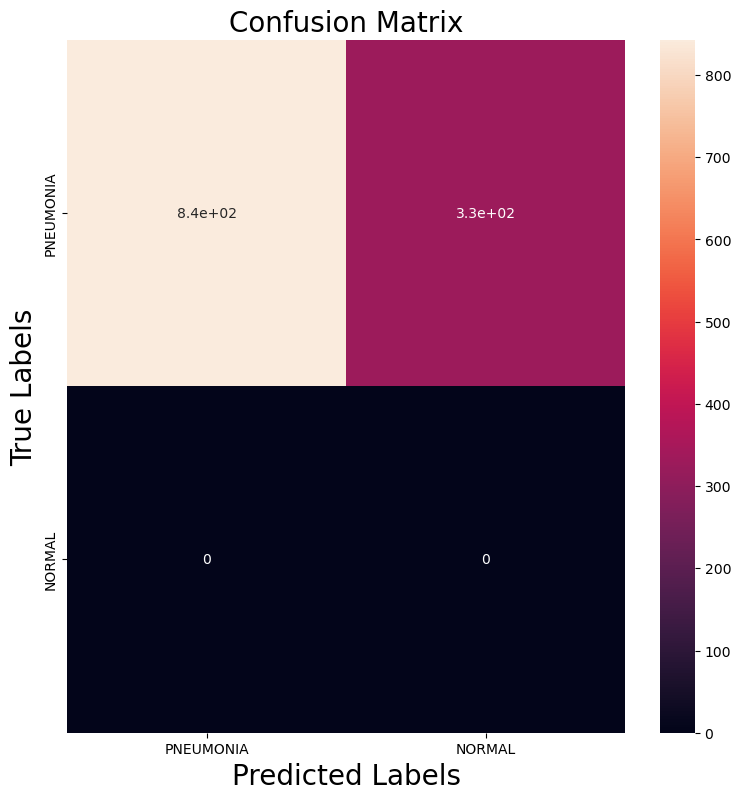

In [42]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt 
import seaborn as sns 
matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(9, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [43]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_pred,y_test)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.72      0.84      1172
           1       0.00      0.00      0.00         0

    accuracy                           0.72      1172
   macro avg       0.50      0.36      0.42      1172
weighted avg       1.00      0.72      0.84      1172



c:\Users\asus\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
